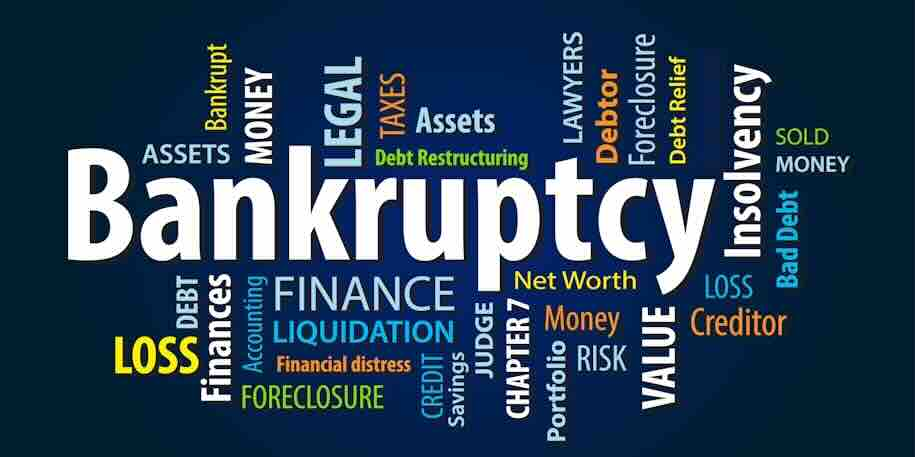

---

### SUMMARY

1. [Introduction](#1)
2. [Read the Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Feature Engineering](#4)
5. [Binary Classification](#5)

---

# 1. Introduction
<a id="1"></a>

The data used here were collected by the Taiwan Economic Journal from 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.
<br>There are 96 columns in this dataset. One contains the target variable *y* (i.e. *Bankrupt?*), the other 95 are predictors. The purpose of this notebook is to predict which companies have gone bankrupt by means of (binary) classification techniques.

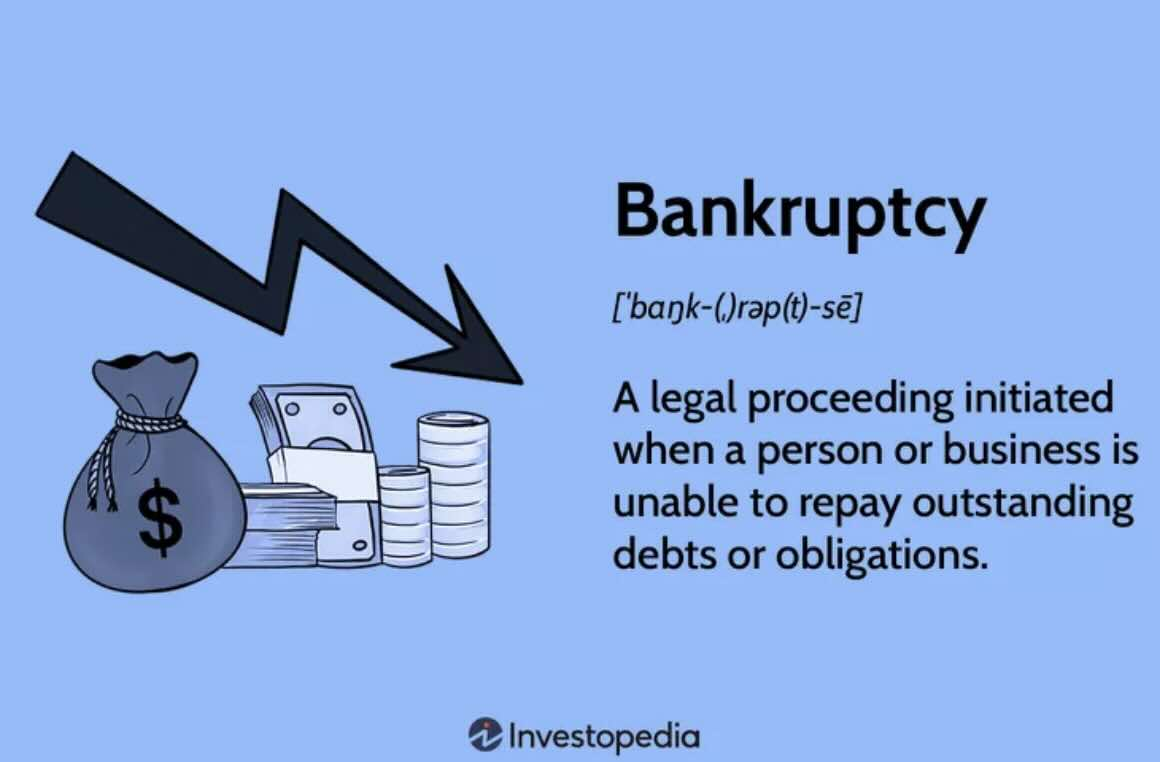

Because of the very large number of predictors, before carrying out the binary classification it will be necessary to reduce the number of features in the *X* matrix, i.e. the number of 95 columns beside that containing the target variable. To do that, I will make use of: 
* The correlation matrix in order to identify the variables with an excessive mutual correlation.
* PCA (principal component analysis) in order to perform dimensionality reduction.

# 2. Read the Data and Brief EDA
<a id="2"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from warnings import simplefilter
simplefilter("ignore")

In [2]:
# Option to display all columns
pd.set_option('display.max_columns', None)

data = pd.read_csv('/kaggle/input/company-bankruptcy-prediction/data.csv')

data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [3]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 6819 rows and 96 columns.


**Null values and duplicate rows**

In [4]:
data.columns[data.isnull().any()]

Index([], dtype='object')

In [5]:
data.duplicated().sum()

0

There are no null values and no duplicate rows in the dataset.

**Columns and Their Meaning**

* Y - Bankrupt?: Class label
* X1 - ROA(C) before interest and depreciation before interest: Return On Total Assets(C)
* X2 - ROA(A) before interest and % after tax: Return On Total Assets(A)
* X3 - ROA(B) before interest and depreciation after tax: Return On Total Assets(B)
* X4 - Operating Gross Margin: Gross Profit/Net Sales
* X5 - Realized Sales Gross Margin: Realized Gross Profit/Net Sales
* X6 - Operating Profit Rate: Operating Income/Net Sales
* X7 - Pre-tax net Interest Rate: Pre-Tax Income/Net Sales
* X8 - After-tax net Interest Rate: Net Income/Net Sales
* X9 - Non-industry income and expenditure/revenue: Net Non-operating Income Ratio
* X10 - Continuous interest rate (after tax): Net Income-Exclude Disposal Gain or Loss/Net Sales
* X11 - Operating Expense Rate: Operating Expenses/Net Sales
* X12 - Research and development expense rate: (Research and Development Expenses)/Net Sales
* X13 - Cash flow rate: Cash Flow from Operating/Current Liabilities
* X14 - Interest-bearing debt interest rate: Interest-bearing Debt/Equity
* X15 - Tax rate (A): Effective Tax Rate
* X16 - Net Value Per Share (B): Book Value Per Share(B)
* X17 - Net Value Per Share (A): Book Value Per Share(A)
* X18 - Net Value Per Share (C): Book Value Per Share(C)
* X19 - Persistent EPS in the Last Four Seasons: EPS-Net Income
* X20 - Cash Flow Per Share
* X21 - Revenue Per Share (Yuan ¥): Sales Per Share
* X22 - Operating Profit Per Share (Yuan ¥): Operating Income Per Share
* X23 - Per Share Net profit before tax (Yuan ¥): Pretax Income Per Share
* X24 - Realized Sales Gross Profit Growth Rate
* X25 - Operating Profit Growth Rate: Operating Income Growth
* X26 - After-tax Net Profit Growth Rate: Net Income Growth
* X27 - Regular Net Profit Growth Rate: Continuing Operating Income after Tax Growth
* X28 - Continuous Net Profit Growth Rate: Net Income-Excluding Disposal Gain or Loss Growth
* X29 - Total Asset Growth Rate: Total Asset Growth
* X30 - Net Value Growth Rate: Total Equity Growth
* X31 - Total Asset Return Growth Rate Ratio: Return on Total Asset Growth
* X32 - Cash Reinvestment %: Cash Reinvestment Ratio
* X33 - Current Ratio
* X34 - Quick Ratio: Acid Test
* X35 - Interest Expense Ratio: Interest Expenses/Total Revenue
* X36 - Total debt/Total net worth: Total Liability/Equity Ratio
* X37 - Debt ratio %: Liability/Total Assets
* X38 - Net worth/Assets: Equity/Total Assets
* X39 - Long-term fund suitability ratio (A): (Long-term Liability+Equity)/Fixed Assets
* X40 - Borrowing dependency: Cost of Interest-bearing Debt
* X41 - Contingent liabilities/Net worth: Contingent Liability/Equity
* X42 - Operating profit/Paid-in capital: Operating Income/Capital
* X43 - Net profit before tax/Paid-in capital: Pretax Income/Capital
* X44 - Inventory and accounts receivable/Net value: (Inventory+Accounts Receivables)/Equity
* X45 - Total Asset Turnover
* X46 - Accounts Receivable Turnover
* X47 - Average Collection Days: Days Receivable Outstanding
* X48 - Inventory Turnover Rate (times)
* X49 - Fixed Assets Turnover Frequency
* X50 - Net Worth Turnover Rate (times): Equity Turnover
* X51 - Revenue per person: Sales Per Employee
* X52 - Operating profit per person: Operation Income Per Employee
* X53 - Allocation rate per person: Fixed Assets Per Employee
* X54 - Working Capital to Total Assets
* X55 - Quick Assets/Total Assets
* X56 - Current Assets/Total Assets
* X57 - Cash/Total Assets
* X58 - Quick Assets/Current Liability
* X59 - Cash/Current Liability
* X60 - Current Liability to Assets
* X61 - Operating Funds to Liability
* X62 - Inventory/Working Capital
* X63 - Inventory/Current Liability
* X64 - Current Liabilities/Liability
* X65 - Working Capital/Equity
* X66 - Current Liabilities/Equity
* X67 - Long-term Liability to Current Assets
* X68 - Retained Earnings to Total Assets
* X69 - Total income/Total expense
* X70 - Total expense/Assets
* X71 - Current Asset Turnover Rate: Current Assets to Sales
* X72 - Quick Asset Turnover Rate: Quick Assets to Sales
* X73 - Working capitcal Turnover Rate: Working Capital to Sales
* X74 - Cash Turnover Rate: Cash to Sales
* X75 - Cash Flow to Sales
* X76 - Fixed Assets to Assets
* X77 - Current Liability to Liability
* X78 - Current Liability to Equity
* X79 - Equity to Long-term Liability
* X80 - Cash Flow to Total Assets
* X81 - Cash Flow to Liability
* X82 - CFO to Assets
* X83 - Cash Flow to Equity
* X84 - Current Liability to Current Assets
* X85 - Liability-Assets Flag: 1 if Total Liability exceeds Total Assets, 0 otherwise
* X86 - Net Income to Total Assets
* X87 - Total assets to GNP price
* X88 - No-credit Interval
* X89 - Gross Profit to Sales
* X90 - Net Income to Stockholder's Equity
* X91 - Liability to Equity
* X92 - Degree of Financial Leverage (DFL)
* X93 - Interest Coverage Ratio (Interest expense to EBIT)
* X94 - Net Income Flag: 1 if Net Income is Negative for the last two years, 0 otherwise
* X95 - Equity to Liability

# 3. Exploratory Data Analysis
<a id="3"></a>

### 3.1 Is the Data Balanced or Imbalanced?

Let's have a look at the target variable to see whether it is balanced or not.

In [6]:
val = data['Bankrupt?'].value_counts().reset_index(name='count')

val

,Bankrupt?,count
0,0,6599
1,1,220


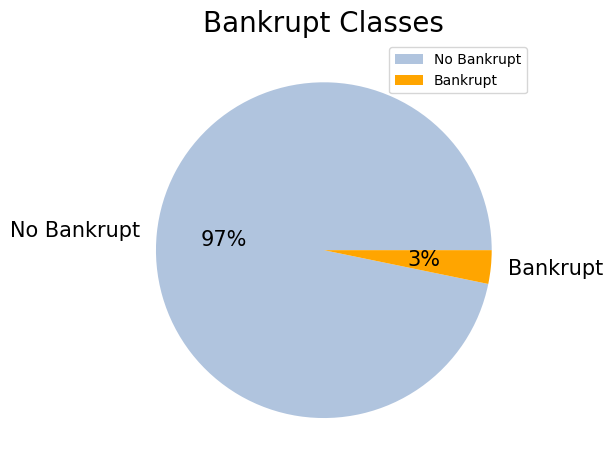

In [7]:
def label_function(val):
    return f'{val:.0f}%'

labels = ['No Bankrupt','Bankrupt']

val.plot(x='Bankrupt?',y='count',kind='pie',autopct=label_function,
                textprops={'fontsize':15},labels=labels,colors=['lightsteelblue','orange'])

plt.ylabel('')
plt.title('Bankrupt Classes',fontsize=20)

plt.tight_layout()

As shown in the plot, the values in the *Bankrupt?* column are highly inbalanced. Therefore, in order to rise the accuracy of the results I will probably have to resample the data to get more balanced classes in the target variable (something around a 50-50 split between the bankrupt classes).

### 3.2 Outliers

Let's have a look at the boxplots of the predictors to see whether they have outliers or not.

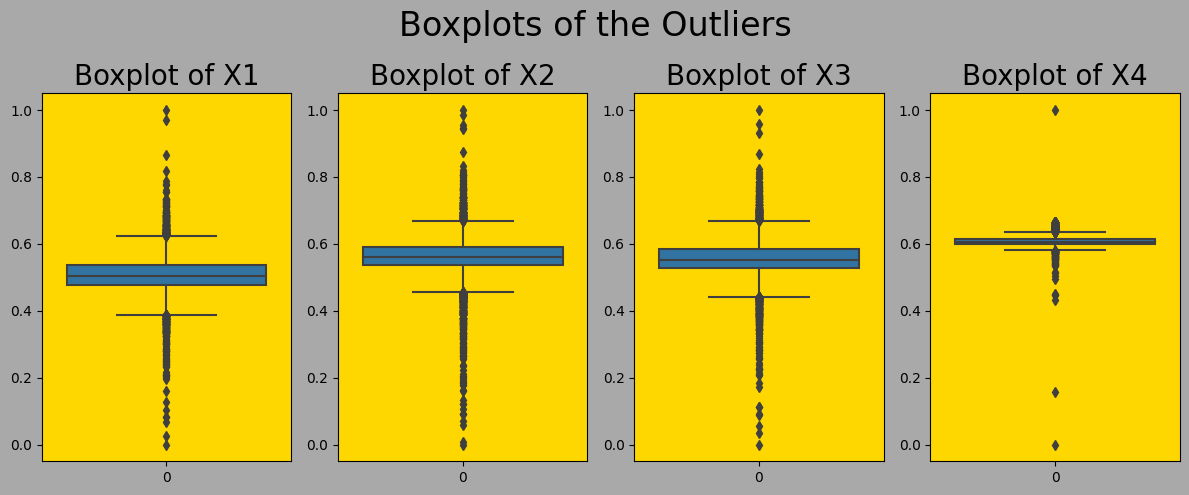

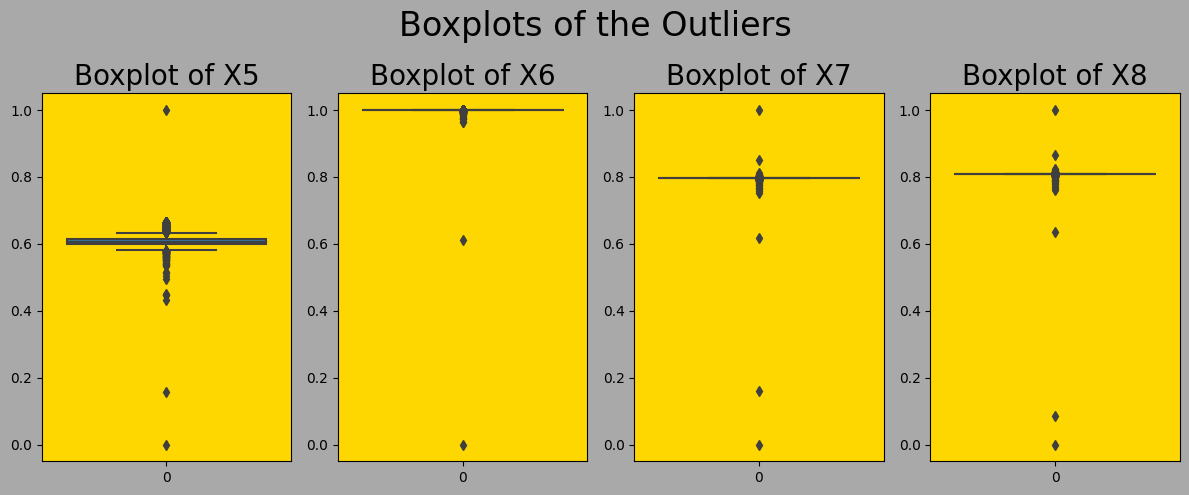

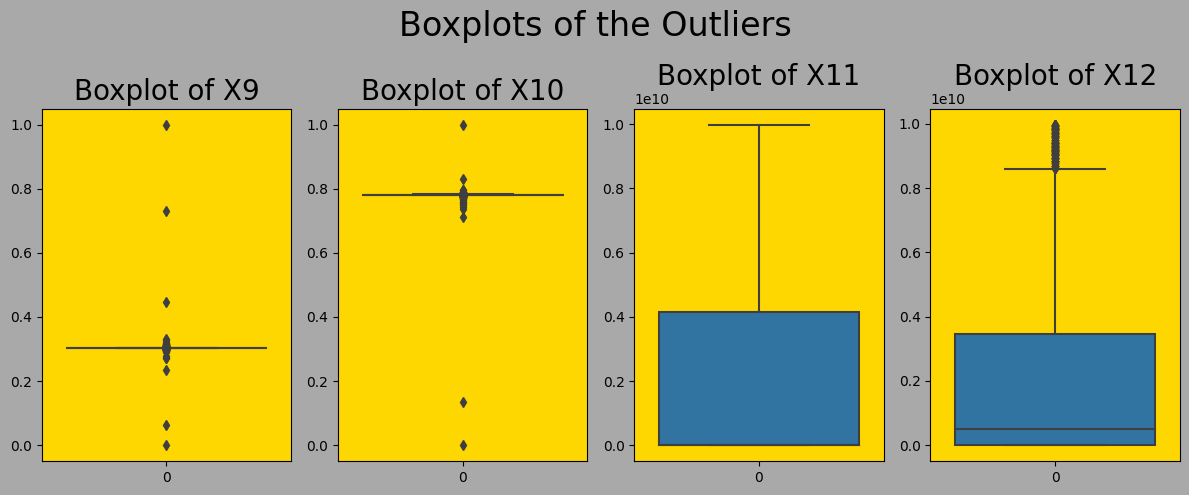

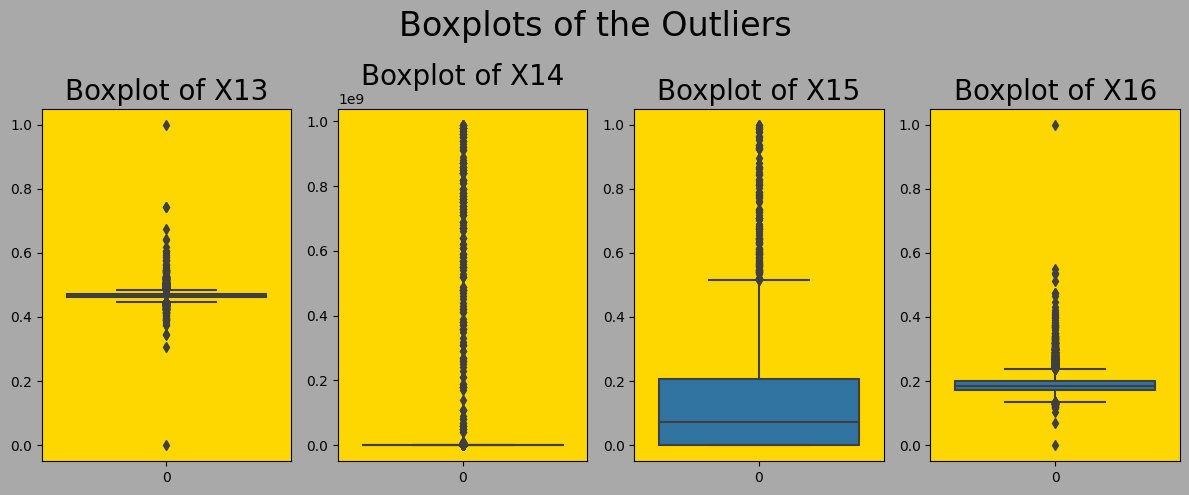

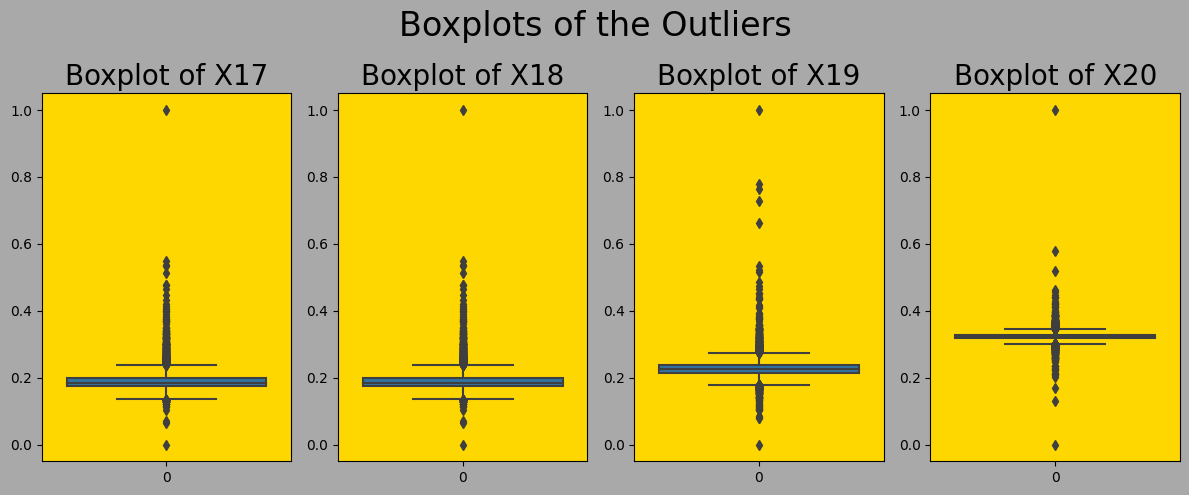

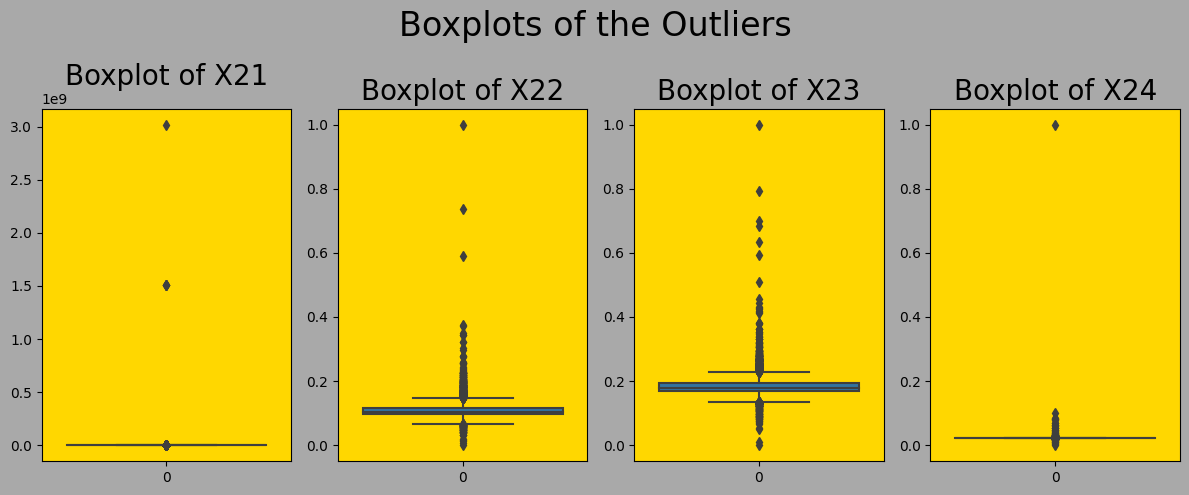

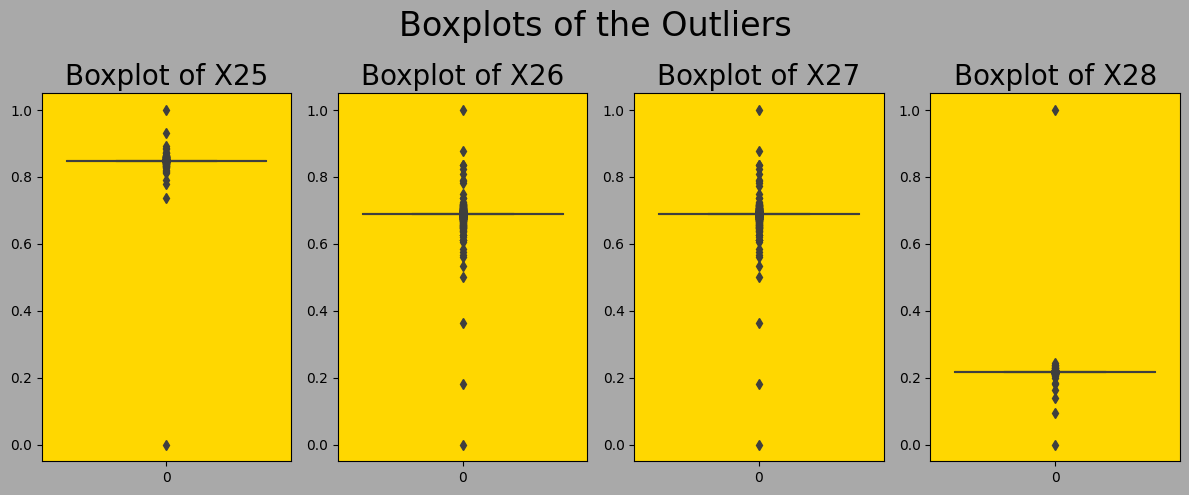

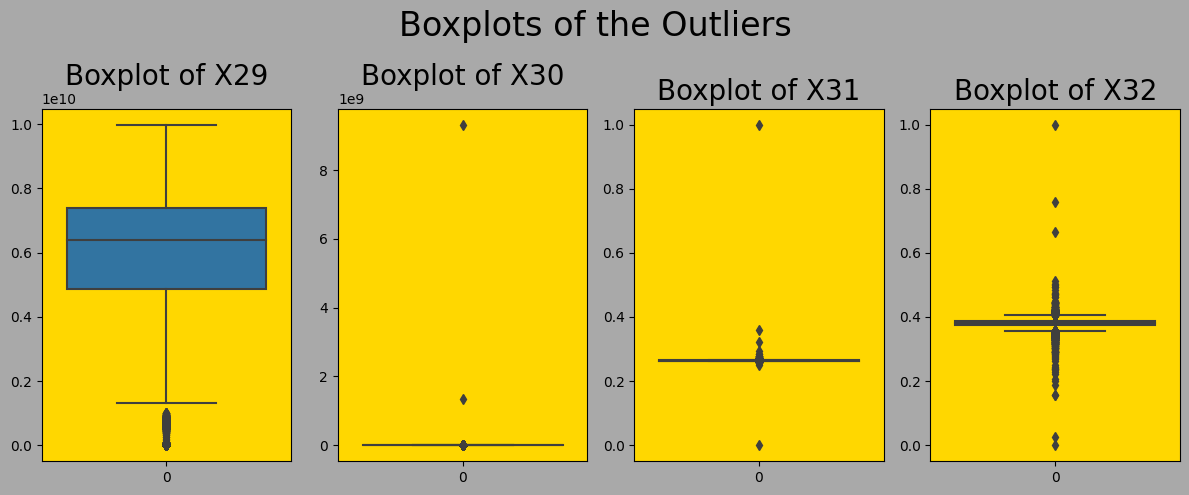

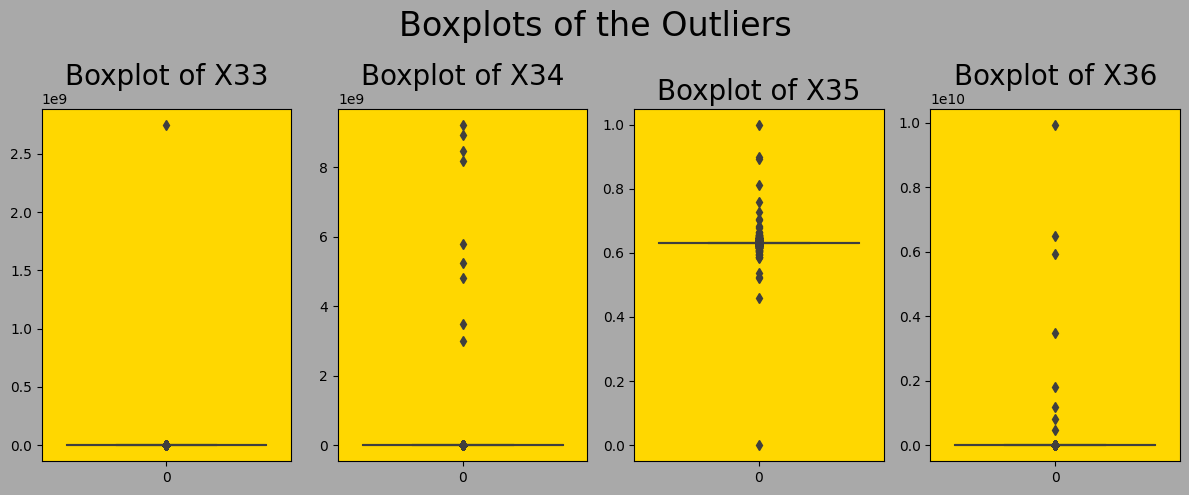

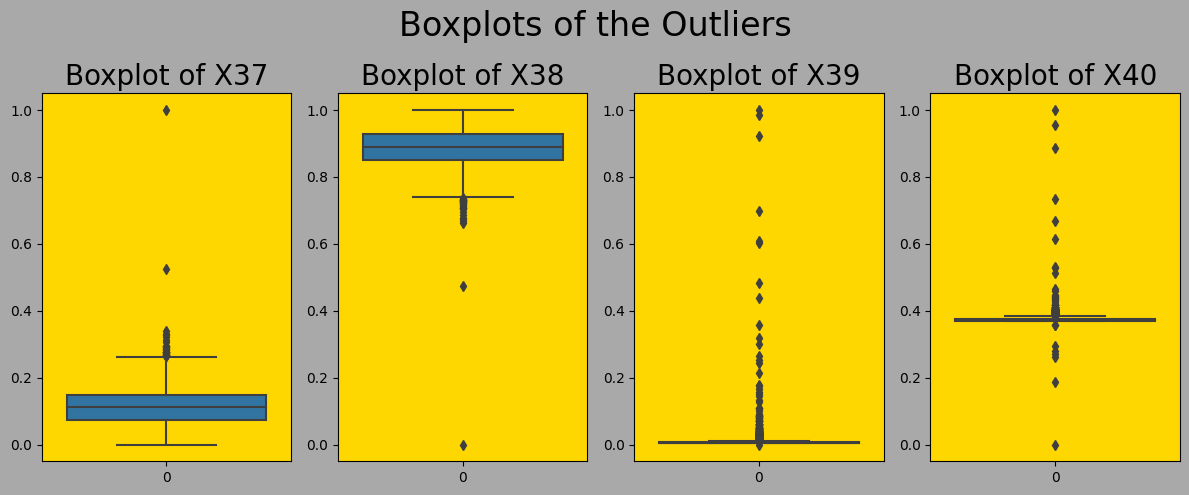

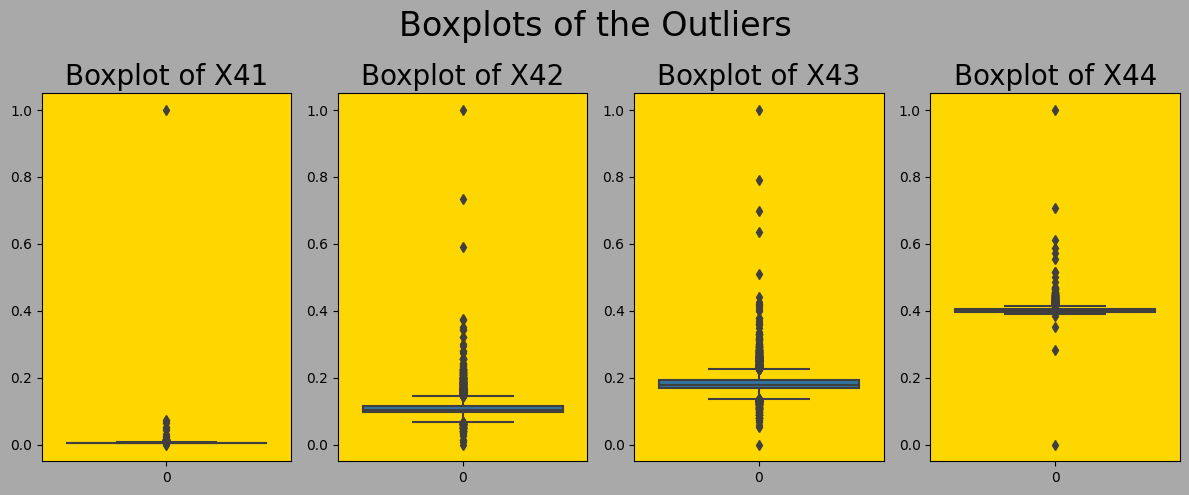

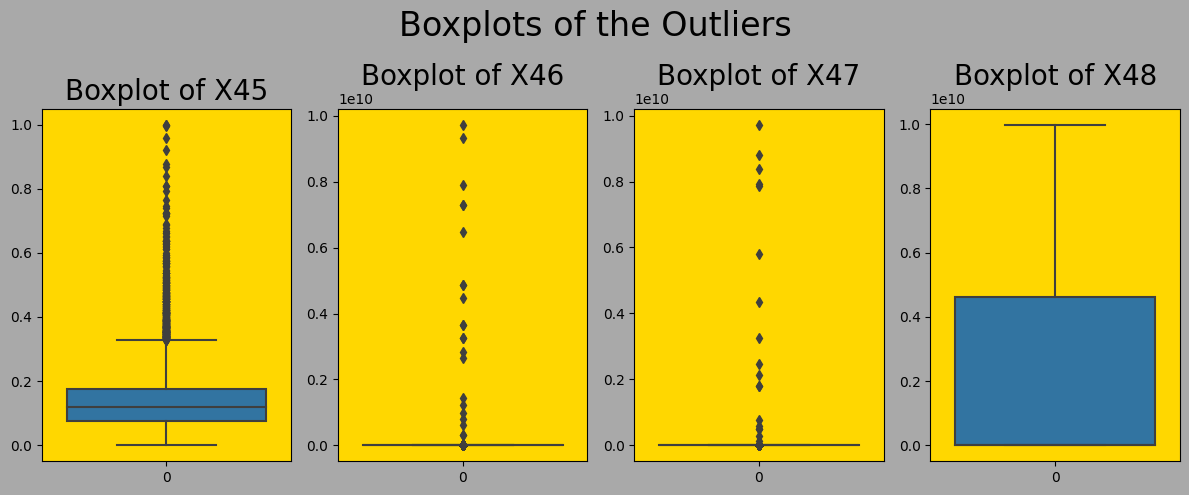

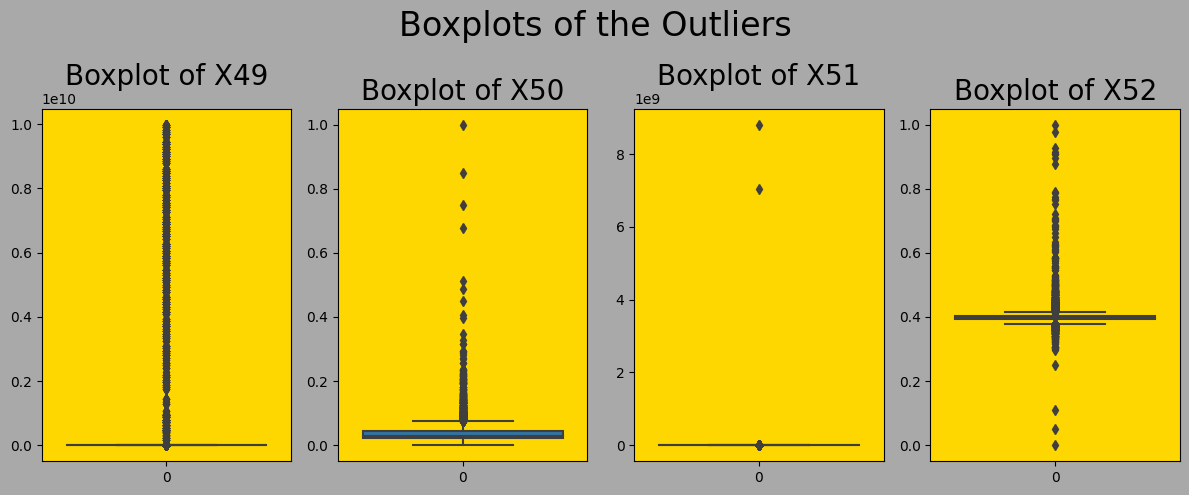

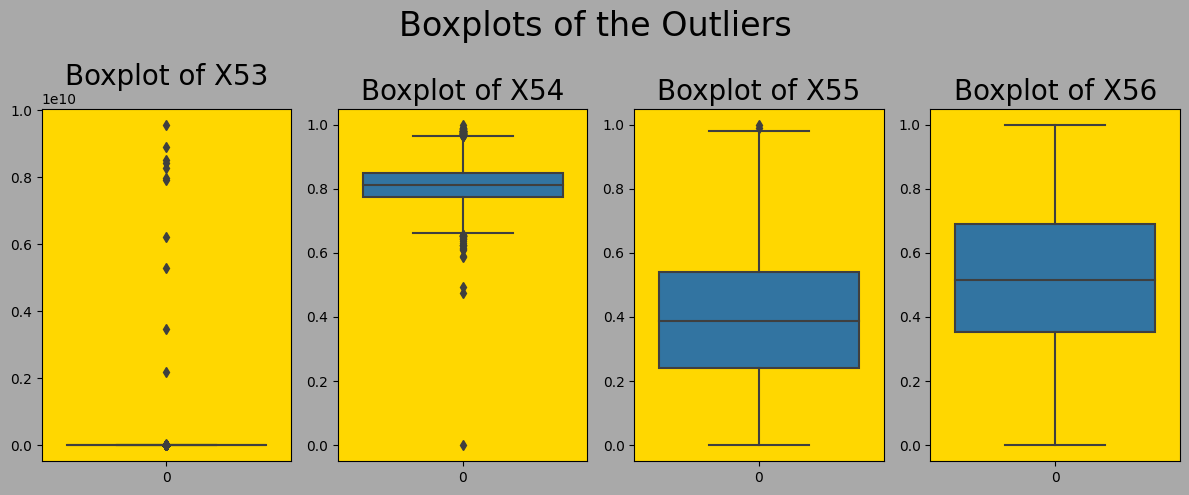

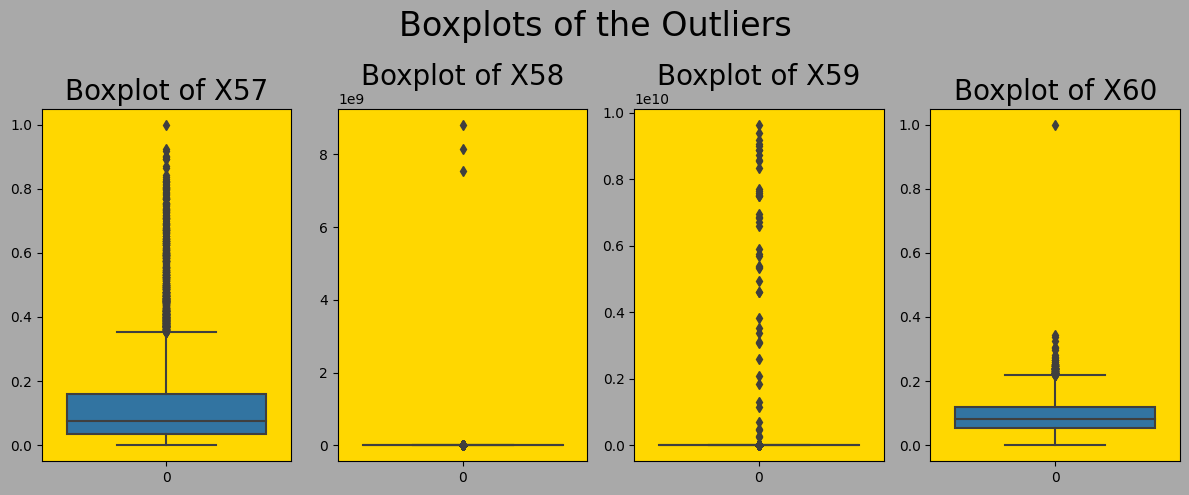

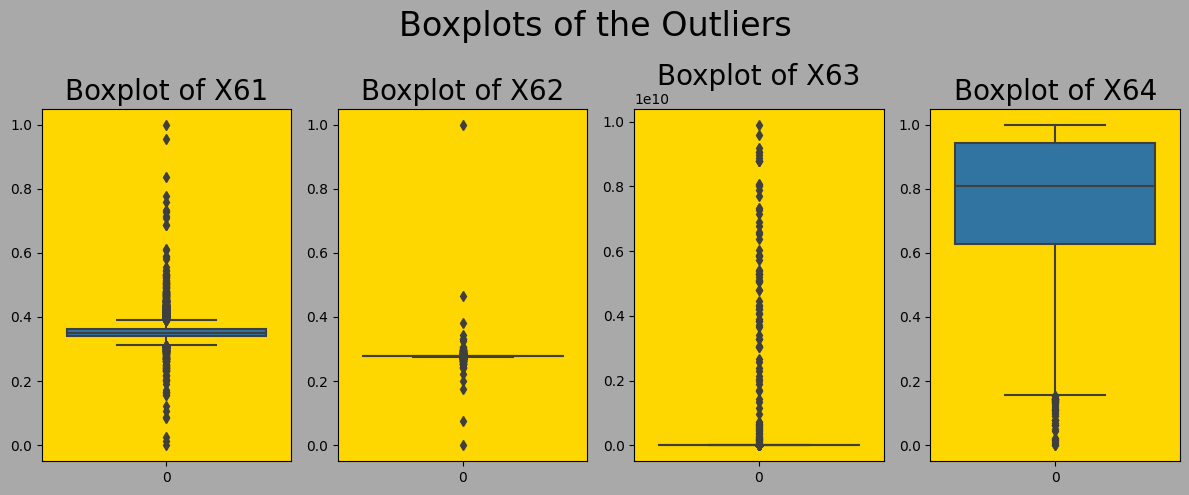

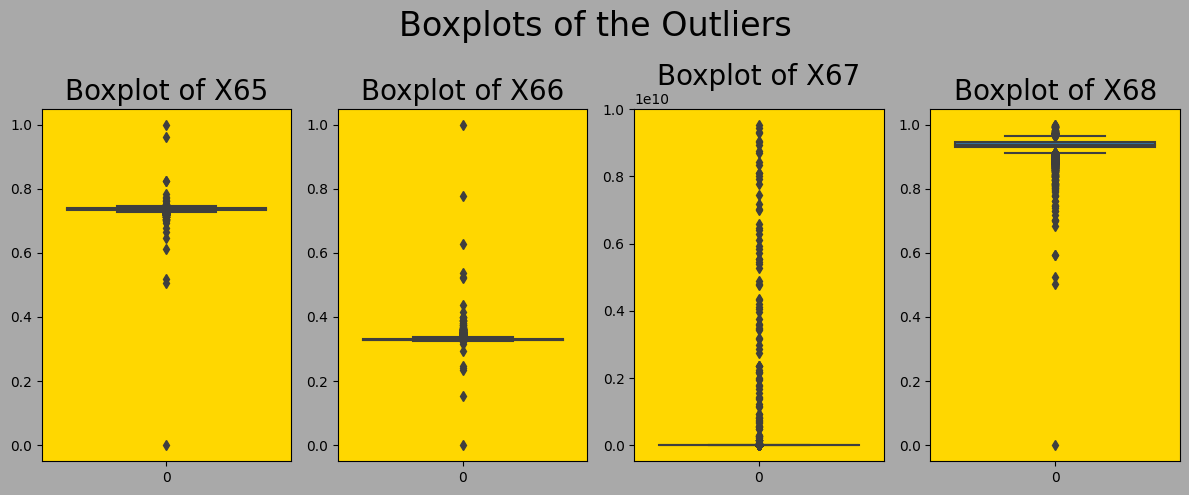

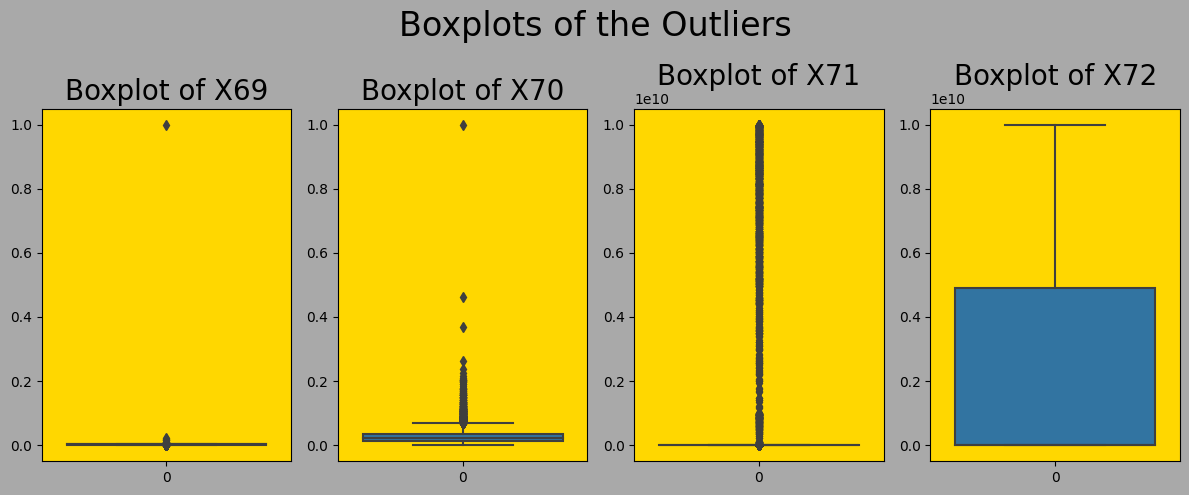

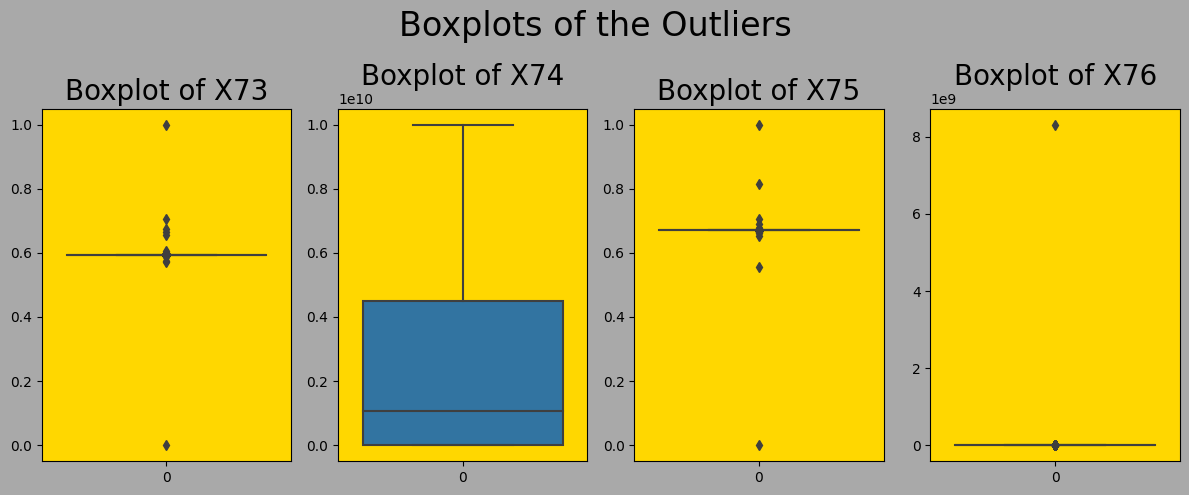

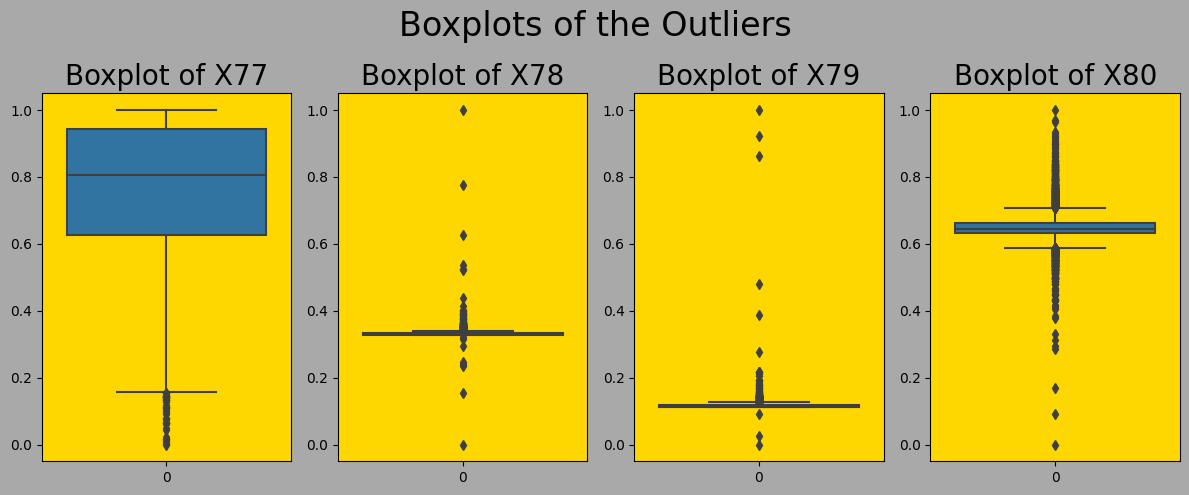

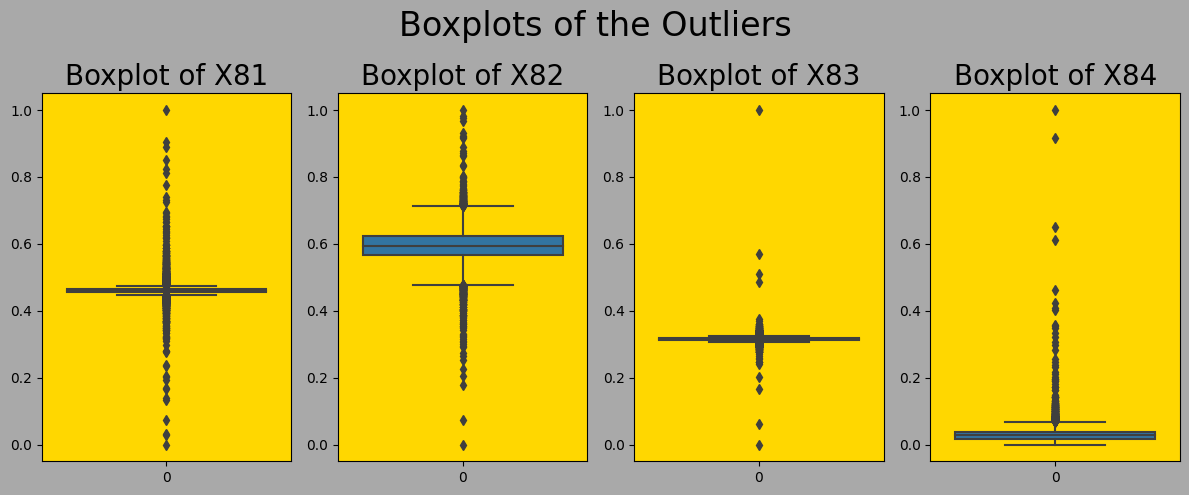

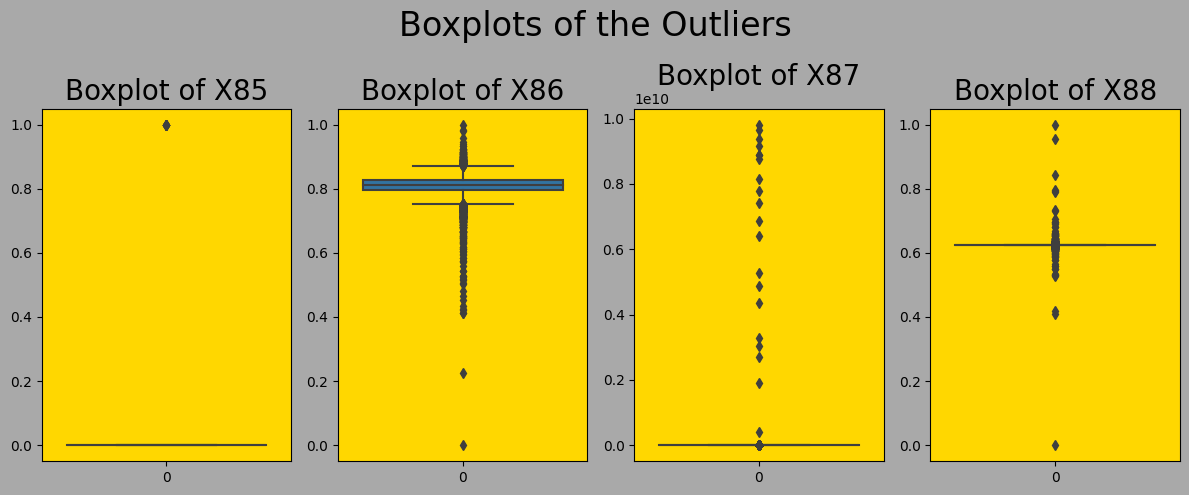

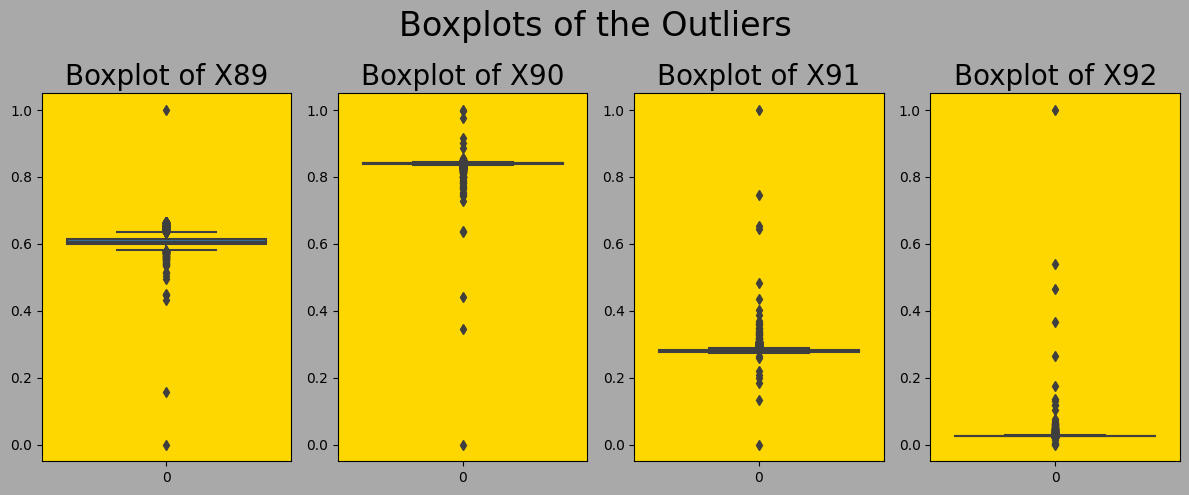

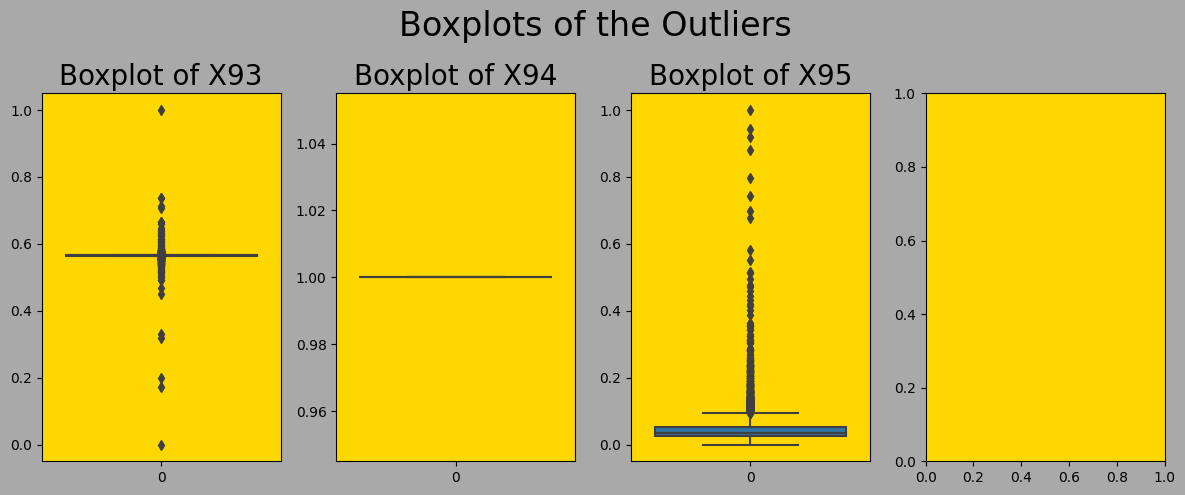

In [8]:
features = data.drop('Bankrupt?',axis=1).columns

for i in range(24):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(data[features[i*4]],ax=ax1)
    ax1.set_title(f'Boxplot of X{i*4+1}',fontsize=20)
    ax1.set_facecolor('gold')
    ax2 = sns.boxplot(data[features[i*4+1]],ax=ax2)
    ax2.set_title(f'Boxplot of X{i*4+2}',fontsize=20)
    ax2.set_facecolor('gold')
    ax3 = sns.boxplot(data[features[i*4+2]],ax=ax3)
    ax3.set_title(f'Boxplot of X{i*4+3}',fontsize=20)
    ax3.set_facecolor('gold')
    if i < 23:
        ax4 = sns.boxplot(data[features[i*4+3]],ax=ax4)
        ax4.set_title(f'Boxplot of X{i*4+4}',fontsize=20)
        ax4.set_facecolor('gold')
    else:    
        ax4.set_facecolor('gold')
    
    fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('darkgrey')

With a few exceptions, the *X*-variables have a large number of outliers.

### 3.3 Correlations

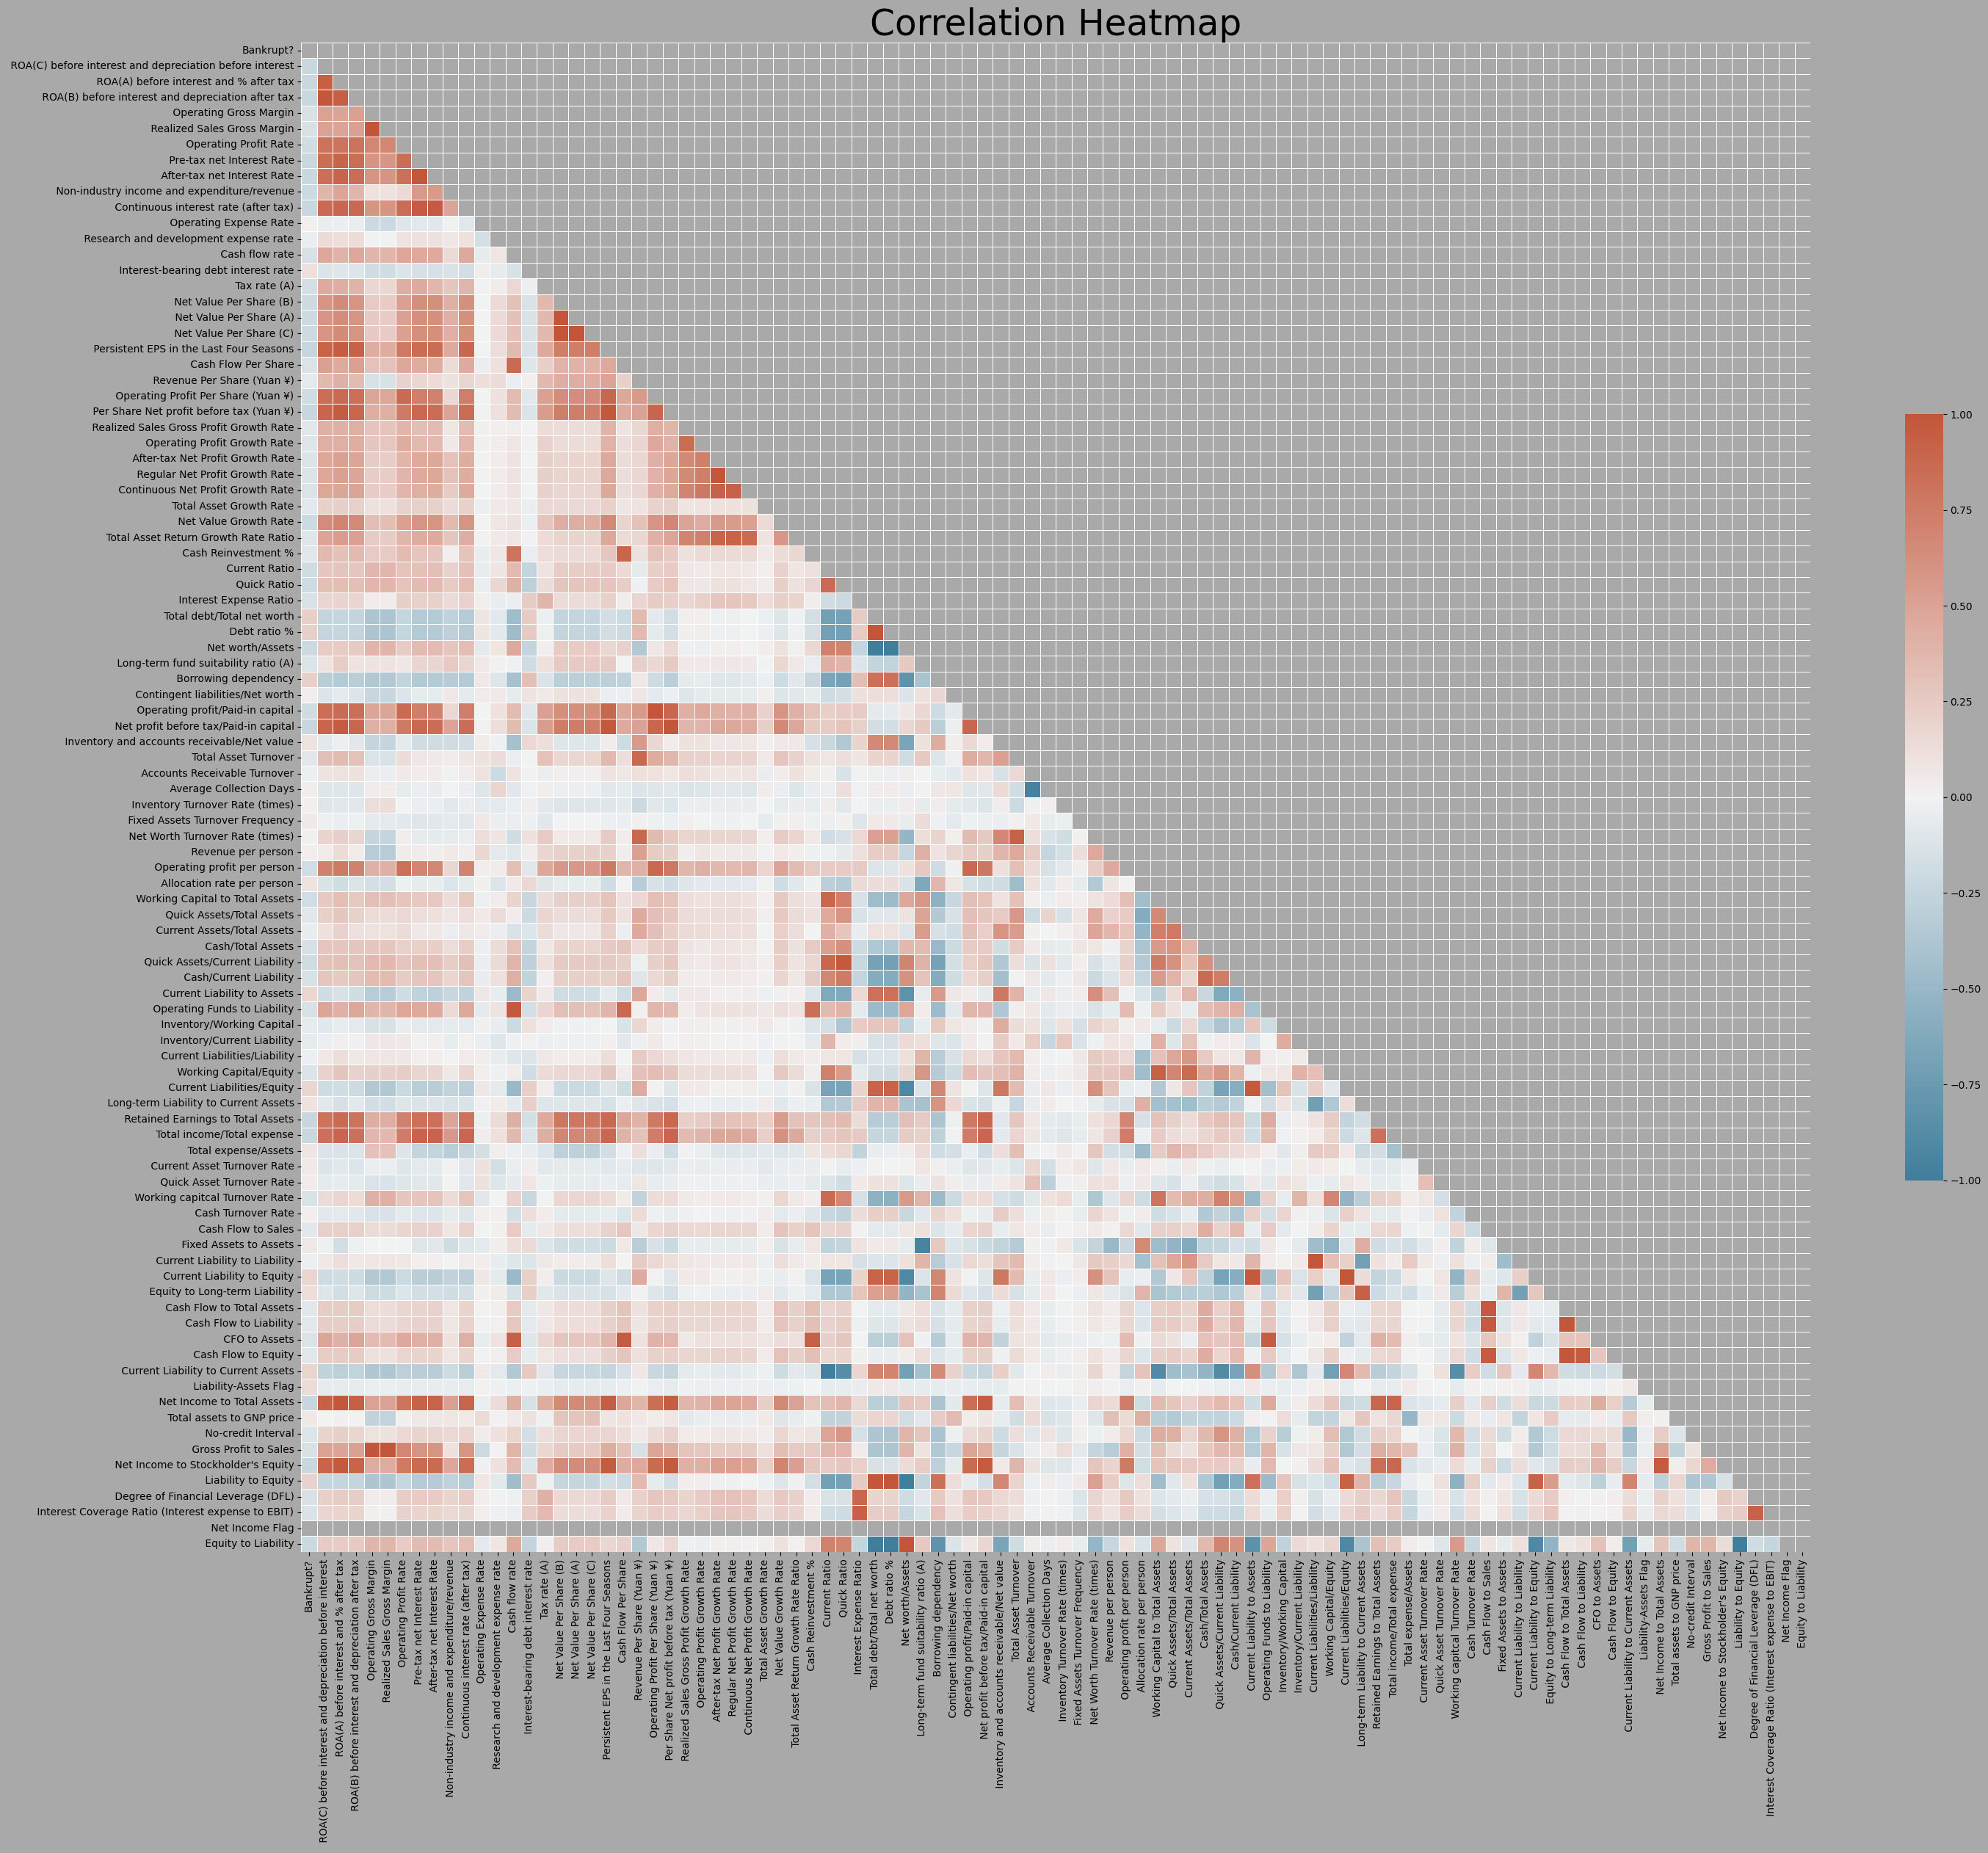

In [9]:
f,ax = plt.subplots(figsize=(30, 25))

mat = data.corr('spearman')
mask = np.triu(np.ones_like(mat,dtype=bool))
cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(mat,mask=mask,cmap=cmap,vmax=1,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

plt.title('Correlation Heatmap',fontsize=35)

plt.tight_layout()
plt.gcf().patch.set_facecolor('darkgrey')
plt.gca().set_facecolor('darkgrey')

plt.show()

There are some strong correlation between the variables. Let's have a look at those couples of features with either *R* > 0.9 or *R* < -0.9.

In [ ]:
list1 = features
list2 = features
list_int = []
count = 1

for col1 in list1:
    list_int.append(col1)
    for col2 in list2:
        if col2 not in list_int:
            R_corr = data.corr().loc[col1,col2]
            if R_corr > 0.9 or R_corr < -0.9:
                print(count,'.  ',col1,' -- ',col2,';  R = {:.3f}'.format(R_corr))   
                count += 1               

1 .    ROA(C) before interest and depreciation before interest  --   ROA(A) before interest and % after tax ;  R = 0.940
2 .    ROA(C) before interest and depreciation before interest  --   ROA(B) before interest and depreciation after tax ;  R = 0.987
3 .    ROA(A) before interest and % after tax  --   ROA(B) before interest and depreciation after tax ;  R = 0.956
4 .    ROA(A) before interest and % after tax  --   Net Income to Total Assets ;  R = 0.962
5 .    ROA(B) before interest and depreciation after tax  --   Net Income to Total Assets ;  R = 0.912
6 .    Operating Gross Margin  --   Realized Sales Gross Margin ;  R = 1.000
7 .    Operating Gross Margin  --   Gross Profit to Sales ;  R = 1.000
8 .    Realized Sales Gross Margin  --   Gross Profit to Sales ;  R = 1.000
9 .    Operating Profit Rate  --   Pre-tax net Interest Rate ;  R = 0.916
10 .    Operating Profit Rate  --   Continuous interest rate (after tax) ;  R = 0.916
11 .    Pre-tax net Interest Rate  --   After-tax net

At least one of the elements in each pair of features with a high value of the Pearson coefficient *R* will have to be dropped.

# 4. Feature Engineering
<a id="4"></a>

### 4.1 Outliers Capping

Outliers are data points that stand out significantly from the rest of the data. They can be extremely high or low values compared to the other observations and can be caused by measurement errors, natural variations in the data, or even unexpected discoveries. It is well-known that the outliers in a dataset (that we want to study via classification or regression techniques) can result in a lower predictive performance; thus they need to be dealt with.

The outliers will be capped by setting (for each column) lower and upper thresholds, that are defined in terms of the first and third quartiles of the data.
<br>The capping procedure has to be carried out on the float variables only. The variables of integer type must be excluded from this procedure.

In [ ]:
# Function for outliers capping
def outlier_imputer(data,features):
    
    data_out = data.copy()
    
    for column in features:        
        
        # First define the first and third quartiles
        Q1 = data_out[column].quantile(0.25)
        Q3 = data_out[column].quantile(0.75)
        # Define the inter-quartile range
        IQR = Q3 - Q1
        # ... and the lower/higher threshold values
        lowerL = (Q1 - 1.5 * IQR)
        higherL = (Q3 + 1.5 * IQR)
        
        # Impute 'left' outliers
        data_out.loc[data_out[column] < lowerL,column] = lowerL
        # Impute 'right' outliers
        data_out.loc[data_out[column] > higherL,column] = higherL
        
    return data_out 

# Outliers capping is carried out on the float columns only
data_in     = data.select_dtypes(include='float')
features_in = data_in.columns

capped_data = outlier_imputer(data_in,features_in)  

In [ ]:
# Integer-type columns are concatenated to the capped dataset
data_int = data.select_dtypes(include='int')

data2 = pd.concat([capped_data,data_int],axis=1)

data2.head()

In [ ]:
for i in range(24):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(data2[features[i*4]],ax=ax1)
    ax1.set_title(f'Boxplot of X{i*4+1}',fontsize=20)
    ax1.set_facecolor('gold')
    ax2 = sns.boxplot(data2[features[i*4+1]],ax=ax2)
    ax2.set_title(f'Boxplot of X{i*4+2}',fontsize=20)
    ax2.set_facecolor('gold')
    ax3 = sns.boxplot(data2[features[i*4+2]],ax=ax3)
    ax3.set_title(f'Boxplot of X{i*4+3}',fontsize=20)
    ax3.set_facecolor('gold')
    if i < 23:
        ax4 = sns.boxplot(data2[features[i*4+3]],ax=ax4)
        ax4.set_title(f'Boxplot of X{i*4+4}',fontsize=20)
        ax4.set_facecolor('gold')
    else:    
        ax4.set_facecolor('gold')
    
    fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('darkgrey')

The boxplots above show that the outliers capping procedure was successful.

### 4.2 Resampling

The data is highly imbalanced because around 97% of the target values belong to one of the binary classes. A 50-50 split of these classes in the test data is needed in order to obtain more accurate predictions.

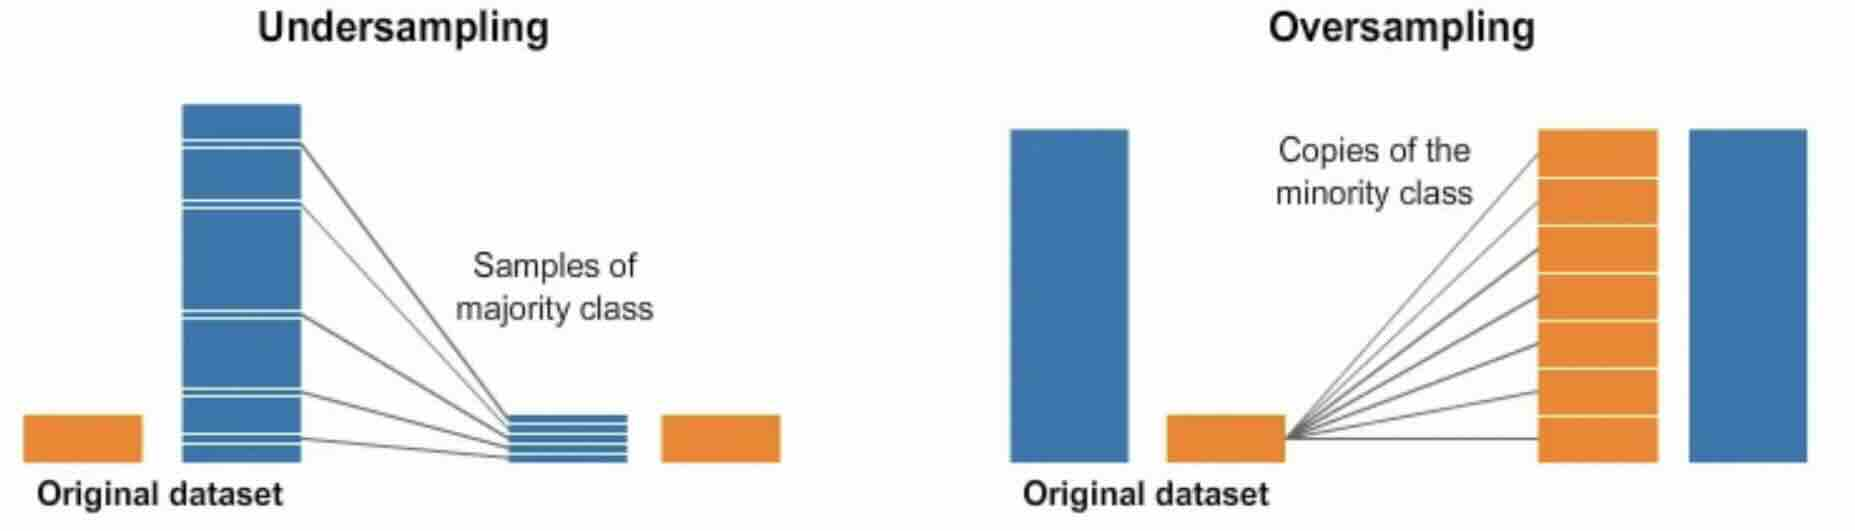

**Train-Test Splitting**

I am defining the *X* and *y* variables.

In [ ]:
X = data2.drop('Bankrupt?',axis=1)
y = data2['Bankrupt?']

Then, I am performing the train-test splitting.

In [ ]:
# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

**Oversampling**

I will start with the oversampling procedure. It consists in copying the rows of the dataset with a target variable value belonging to the minority class, so that their number is the same as that of the rows with a target variable value belonging to the majority class.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# Balancing the data
X_overSampled,y_overSampled = smote.fit_resample(X_train,y_train)

In [ ]:
len(X_train), len(X_overSampled)

**Undersampling**

Undersampling is the opposite to oversampling. In this second case, the number of rows with a target variable value belonging to the majority class is cut, so that their number is the same as that of the rows with a target variable value belonging to the minority class.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')

# Balancing the data
X_underSampled,y_underSampled = rus.fit_resample(X_train,y_train)

In [ ]:
len(X_train), len(X_underSampled)

# 5. Binary Classification with Feature Selection
<a id="5"></a>

I am using a feature selection method, where I will 'manually' select those features that have a high relative feature importance (calculate by means of a random forest classifier) and do not have a strong correlation with other variables.

**Scaling**

In [ ]:
X_test_under = X_test.copy()

### Undersampled data ###
LABELS = X_underSampled.columns

## Scaling ##       
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
X_underSampled[LABELS] = mm_scaler.fit_transform(X_underSampled[LABELS])
X_test_under[LABELS] = mm_scaler.transform(X_test_under[LABELS])

In [ ]:
X_test_over = X_test.copy()

### Oversampled data ###
LABELS = X_overSampled.columns

## Scaling ##       
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
X_overSampled[LABELS] = mm_scaler.fit_transform(X_overSampled[LABELS])
X_test_over[LABELS] = mm_scaler.transform(X_test_over[LABELS])

**Feature Importance**

I am calculating the relative importance of the predictors by means of a random forest classifier. Although this method is not 100% reliable, it can give indications about the most/less useful features in the classification stage. I will use **undersampled train data**.

In [ ]:
# Random Forest Model
random_forest = RandomForestClassifier(random_state=1,max_depth=4)
random_forest.fit(X_underSampled,y_underSampled)

importances = pd.DataFrame({'feature':X_underSampled.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False) 

importances

I am keeping the features with a relative importance > 2% only.

In [ ]:
importances = importances[importances['importance'] > 0.02]

importances

**Dropping some features**

I am turning the features that are displayed in the *feature* column into a list.

In [ ]:
list_features = importances['feature'].to_list()

list_features

Some of these features have strong mutual correlations, like ROA(C) vs ROA(B). This is why some of them must be dropped. I will drop those that are here in the list below and also have lower feature importance.

1.    ROA(C) before interest and depreciation before interest  --   ROA(A) before interest and % after tax ;  R = 0.940
2.    ROA(C) before interest and depreciation before interest  --   ROA(B) before interest and depreciation after tax ;  R = 0.987
3.    ROA(A) before interest and % after tax  --   ROA(B) before interest and depreciation after tax ;  R = 0.956
4.    ROA(A) before interest and % after tax  --   Net Income to Total Assets ;  R = 0.962
5.    ROA(B) before interest and depreciation after tax  --   Net Income to Total Assets ;  R = 0.912
6.    Operating Gross Margin  --   Realized Sales Gross Margin ;  R = 1.000
7.    Operating Gross Margin  --   Gross Profit to Sales ;  R = 1.000
8.    Realized Sales Gross Margin  --   Gross Profit to Sales ;  R = 1.000
9.    Operating Profit Rate  --   Pre-tax net Interest Rate ;  R = 0.916
10.    Operating Profit Rate  --   Continuous interest rate (after tax) ;  R = 0.916
11.    Pre-tax net Interest Rate  --   After-tax net Interest Rate ;  R = 0.986
12.    Pre-tax net Interest Rate  --   Continuous interest rate (after tax) ;  R = 0.994
13.    After-tax net Interest Rate  --   Continuous interest rate (after tax) ;  R = 0.984
14.    Net Value Per Share (B)  --   Net Value Per Share (A) ;  R = 0.999
15.    Net Value Per Share (B)  --   Net Value Per Share (C) ;  R = 0.999
16.    Net Value Per Share (A)  --   Net Value Per Share (C) ;  R = 1.000
17.    Persistent EPS in the Last Four Seasons  --   Per Share Net profit before tax (Yuan ¥) ;  R = 0.956
18.    Persistent EPS in the Last Four Seasons  --   Net profit before tax/Paid-in capital ;  R = 0.959
19.    Operating Profit Per Share (Yuan ¥)  --   Operating profit/Paid-in capital ;  R = 0.999
20.    Per Share Net profit before tax (Yuan ¥)  --   Net profit before tax/Paid-in capital ;  R = 0.963
21.    After-tax Net Profit Growth Rate  --   Regular Net Profit Growth Rate ;  R = 0.996
22.    Debt ratio %  --   Net worth/Assets ;  R = -1.000
23.    Borrowing dependency  --   Liability to Equity ;  R = 0.956
24.    Current Liabilities/Liability  --   Current Liability to Liability ;  R = 1.000
25.    Current Liabilities/Equity  --   Current Liability to Equity ;  R = 1.000
26.    Current Liabilities/Equity  --   Liability to Equity ;  R = 0.964
27.    Working capitcal Turnover Rate  --   Cash Flow to Sales ;  R = 0.948
28.    Current Liability to Equity  --   Liability to Equity ;  R = 0.964

I will drop: 
* ROA(A)
* ROA(C)
* Per Share Net profit before tax (Yuan ¥)
* Net profit before tax/Paid-in capital
* Debt ratio %
* Liability to Equity

In [ ]:
list_remove = [' ROA(A) before interest and % after tax',
               ' ROA(C) before interest and depreciation before interest',
               ' Per Share Net profit before tax (Yuan ¥)',
               ' Net profit before tax/Paid-in capital',
               ' Debt ratio %',
               ' Liability to Equity']

list_features = list(set(list_features) - set(list_remove))

list_features

Then, I am keeping in the *X* matrix only the features that are displayed in this list.

In [ ]:
X_train_US2 = X_underSampled[X_underSampled.columns.intersection(list_features)]
X_test_US2  = X_test_under[X_test_under.columns.intersection(list_features)]

X_train_OS2 = X_overSampled[X_overSampled.columns.intersection(list_features)]
X_test_OS2  = X_test_over[X_test_over.columns.intersection(list_features)]

X_test_US2.head()

**Binary Classification with a Random Forest Classifier on Undersampled Data**

Now, I am performing a binary classification with a random forest classifier on undersampled data.

I am defining a function to get the most common scores on the classification outcome.

In [ ]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table 

I am fitting the model on the train data, calculating the scores on the train data ...

In [ ]:
random_forest = RandomForestClassifier(class_weight='balanced')

random_forest.fit(X_train_US2,y_underSampled)

# Use the model to predict on train data
rf_train_preds = random_forest.predict(X_train_US2)

rf_train_results = get_test_scores('RF (train, undersampled)',rf_train_preds,y_underSampled)
rf_train_results

... then, I am calculating the scores on the test data.

In [ ]:
# Use the model to predict on test data
rf_test_preds = random_forest.predict(X_test_US2)

rf_test_results = get_test_scores('RF (test, undersampling)',rf_test_preds,y_test)
rf_test_results

Precision and F1 scores are not very good. Let's try to improve them.

**Binary Classification with a XGBoost Classifier on Undersampled Data**

I am doing the same as before, but this time I will use XGBoost instead of a random forest classifier.

In [ ]:
# Instantiate the XGBoost classifier
xgb1 = XGBClassifier(objective='binary:logistic',random_state=42)

xgb1.fit(X_train_US2,y_underSampled)

# Use the model to predict on train data
xgb_train_preds = xgb1.predict(X_train_US2)

xgb_train_results = get_test_scores('XGB (train, undersampled)',xgb_train_preds,y_underSampled)
xgb_train_results

In [ ]:
# Use the model to predict on test data
xgb_test_preds = xgb1.predict(X_test_US2)

xgb_test_results = get_test_scores('XGB (test, undersampling)',xgb_test_preds,y_test)
xgb_test_results   

The results are worse than the random forest ones.

**Binary Classification with a XGBoost Classifier (and GridSearch + Cross Validation) on Undersampled Data**

I am using a XGBoost classifier with GridSearch and cross validation. This will make it possible to vary the parameter values and find the best combination of them.

In [ ]:
# Instantiate the XGBoost classifier
xgb2 = XGBClassifier(objective='binary:logistic',random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth':[None,2,3,4,5],'min_child_weight':[4,5,6],'learning_rate': [0.01,0.05,0.1,0.2],
             'n_estimators':[150,200,300]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb2,cv_params,scoring=scoring,cv=4,refit='accuracy')

In [ ]:
# Model fitting on the train data
xgb_cv.fit(X_train_US2,y_underSampled)

In [ ]:
# Use the model to predict on the test data
xgb_cv_test_preds = xgb_cv.best_estimator_.predict(X_test_US2)

xgb_cv_test_results = get_test_scores('XGB CV (test, undersampling)',xgb_cv_test_preds,y_test)

xgb_cv_test_results   

These results are not better than those obtained with the random forest classifier.

**Confusion Matrix**

In [ ]:
# Generate array of values for confusion matrix
cm_rf_test     = confusion_matrix(y_test,rf_test_preds,labels=random_forest.classes_)
cm_xgb_test    = confusion_matrix(y_test,xgb_test_preds,labels=xgb1.classes_)
cm_xgb_cv_test = confusion_matrix(y_test,xgb_cv_test_preds,labels=xgb_cv.classes_)

### Creating the confusion matrices ###   
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,4))

ax1 = sns.heatmap(cm_rf_test,annot=True,ax=ax1,fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax1.set_title('Random Forest (Test)',fontsize=18)

ax2 = sns.heatmap(cm_xgb_test,annot=True,ax=ax2,fmt='.4g')
ax2.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax2.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax2.set_title('XGBoost (Test)',fontsize=18)

ax3 = sns.heatmap(cm_xgb_cv_test,annot=True,ax=ax3,fmt='.4g')
ax3.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax3.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax3.set_title('XGBoost CV (Test)',fontsize=18)

fig.suptitle("Confusion Matrices of Different Models (Undersampling)",fontsize=24) 

plt.tight_layout()
fig.set_facecolor('darkgrey')

The random forest classifier provides the best results with undersampling.

**Binary Classification with a Random Forest Classifier on Oversampled Data**

I am doing basically the same as before, but I will use oversampled instead of undersampled data.

In [ ]:
random_forest = RandomForestClassifier(class_weight='balanced')

random_forest.fit(X_train_OS2,y_overSampled)

# Use the model to predict on train data
rf_train_preds = random_forest.predict(X_train_OS2)

rf_train_results = get_test_scores('RF (train, oversampled)',rf_train_preds,y_overSampled)
rf_train_results

In [ ]:
# Use the model to predict on test data
rf_test_preds = random_forest.predict(X_test_OS2)

rf_test_over_results = get_test_scores('RF (test, oversampling)',rf_test_preds,y_test)
rf_test_over_results     

It seems that the use of an oversampled train set improves the results.

**Binary Classification with a XGBoost Classifier (and GridSearch + Cross Validation) on Oversampled Data**

In [ ]:
%%time
xgb_cv.fit(X_train_OS2,y_overSampled)

In [ ]:
# Use the model to predict on test data
xgb_cv_test_preds = xgb_cv.best_estimator_.predict(X_test_OS2)

xgb_cv_test_over_results = get_test_scores('XGB CV (test, oversampling)',xgb_cv_test_preds,y_test)

xgb_cv_test_over_results    

**Binary Classification with a Random Forest Classifier (and GridSearch + Cross Validation) on Oversampled Data**

In [ ]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [2,3,4,5,None],'max_features': [1.0],'max_samples': [1.0],
             'min_samples_leaf': [2,3,4],'min_samples_split': [2,3,4],'n_estimators': [200,300,400]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf,cv_params,scoring=scoring,cv=4,refit='accuracy')

In [ ]:
%%time
rf_cv.fit(X_train_OS2,y_overSampled)

In [ ]:
# Use the model to predict on test data
rf_grid_test_preds = rf_cv.best_estimator_.predict(X_test_OS2)

rf_grid_test_over_results = get_test_scores('RF Grid (test, oversampling)',rf_grid_test_preds,y_test)

rf_grid_test_over_results   

In [ ]:
# Generate array of values for confusion matrix
cm_rf2_test     = confusion_matrix(y_test,rf_test_preds,labels=random_forest.classes_)
cm_xgb2_test    = confusion_matrix(y_test,xgb_cv_test_preds,labels=xgb_cv.classes_)
cm_rf2_cv_test  = confusion_matrix(y_test,rf_grid_test_preds,labels=rf_cv.classes_)

### Creating the confusion matrices ###   
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,4))

ax1 = sns.heatmap(cm_rf2_test,annot=True,ax=ax1,fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax1.set_title('Random Forest (Test)',fontsize=18)

ax2 = sns.heatmap(cm_xgb2_test,annot=True,ax=ax2,fmt='.4g')
ax2.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax2.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax2.set_title('XGBoost (Test)',fontsize=18)

ax3 = sns.heatmap(cm_rf2_cv_test,annot=True,ax=ax3,fmt='.4g')
ax3.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax3.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax3.set_title('Random Forest CV (Test)',fontsize=18)

fig.suptitle("Confusion Matrices of Different Models (Oversampling)",fontsize=24) 

plt.tight_layout()
fig.set_facecolor('darkgrey')

**Comparison Between the Different Models**

In [ ]:
results = pd.concat([rf_test_results,xgb_test_results,xgb_cv_test_results,
                     rf_test_over_results,xgb_cv_test_over_results,rf_grid_test_over_results],axis=0)

results.sort_values(by=['accuracy'],ascending=False)

# Useful Reads

[1] Jacopo Ferretti, [*Bank Marketing Campaign (Segmentation + Binary Classification)*](https://www.kaggle.com/code/jacopoferretti/bank-marketing-campaign-segment-binary-classif), Kaggle.

[2] Jacopo Ferretti, [*Credit Card Fraud Detection (Resampling + Cross Validation)*](https://www.kaggle.com/code/jacopoferretti/credit-card-fraud-detection-resampling-cross-val), Kaggle.